<a href="https://colab.research.google.com/github/PatTheAtak/greater-lesser-flamingo-classifier/blob/main/Greater_v_Lesser_Flamingo_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Greater vs Lesser Flamingo Classifier

The basic steps we'll take are:

1. Use DuckDuckGo to search for images of "greater flamingo photos"
1. Use DuckDuckGo to search for images of "lesser flamingo photos"
1. Fine-tune a pretrained neural network to recognise these two groups
1. Try running this model on a picture of a bird and see if it works.

In [1]:
!pip install -Uqq fastai duckduckgo_search

## 1. Download images of Greater and Lesser Flamingos

In [2]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

### Start by searching for a photo of a Greater Flamingo and see what kind of results we get.

In [3]:
urls = search_images('greater flamingo photos', max_images=1)
urls[0]

Searching for 'greater flamingo photos'


'http://www.atozpictures.com/uploads/2016/11/greater-flamingo-birds-gallery.jpg'

..... download a URL and take a look at it.

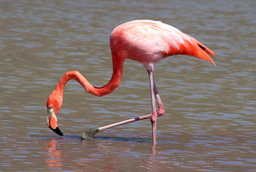

In [4]:
from fastdownload import download_url
dest = 'greater-flamingo.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

.... the same for a lesser flamingo.

Searching for 'lesser flamingo photos'


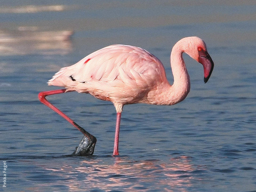

In [5]:
download_url(search_images('lesser flamingo photos', max_images=1)[0], 'lesser-flamingo.jpg', show_progress=False)
Image.open('lesser-flamingo.jpg').to_thumb(256,256)

Searches seem to give reasonable results, so grab a few examples of each of "greater flamingo" and "lesser flamingo" photos, and save each group of photos to a different folder (I'm also trying to grab a range of lighting conditions here):

In [6]:
searches = 'greater flamingo','lesser flamingo'
path = Path('greater_flamingo_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'greater flamingo photo'
Searching for 'greater flamingo sun photo'
Searching for 'greater flamingo shade photo'
Searching for 'lesser flamingo photo'
Searching for 'lesser flamingo sun photo'
Searching for 'lesser flamingo shade photo'


## 2. Train The Model

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [7]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

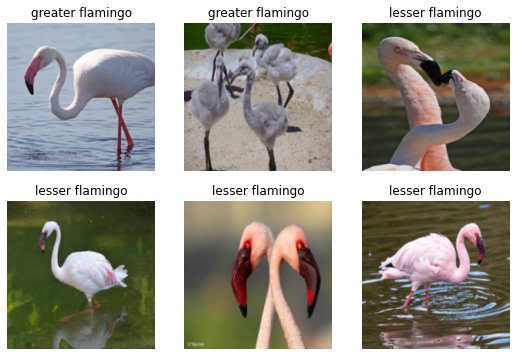

In [8]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [9]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,1.313190,0.543615,0.260870,00:03


epoch,train_loss,valid_loss,error_rate,time
0,0.593256,0.285773,0.086957,00:02
1,0.449193,0.320432,0.144928,00:02
2,0.348357,0.254986,0.086957,00:02


See what the model thinks about that greater flamingo we downloaded at the start:

In [10]:
is_greater,_,probs = learn.predict(PILImage.create('greater-flamingo.jpg'))
print(f"This is a: {is_greater}.")
print(f"Probability it's a greater flamingo: {probs[0]:.4f}")

This is a: greater flamingo.
Probability it's a greater flamingo: 0.6753
